# Predicting Credit Card Default

## 1. Project Overview

**1.1. Introduction:**

Predicting credit card defaults not only helps financial institutions mitigate losses but also allows them to understand customer behavior more deeply, ensuring more sustainable lending practices. This project utilizes the [Default of Credit Card Clients Dataset](https://www.kaggle.com/datasets/uciml/default-of-credit-card-clients-dataset), which encompasses demographic and credit information of 30,000 credit card clients in Taiwan, captured through 24 distinct features from April to September 2005. The central challenge of this project is to predict whether a client will default on their next month's payment, framing it as a binary classification problem.

**1.2 Project Goals:**

In this project, we aim to go beyond merely constructing predictive models. Our specific objectives include:

- To achieve an F1-score greater than a baseline classifier for the minority class, which is indicative of clients likely to default, thus enhancing the model's ability to accurately identify potential defaulters.
- Investigate and apply feature engineering techniques to improve the predictive performance of our models, focusing on deriving new features that might capture more nuances in the data.
- Uncover and provide insights into the key factors that drive credit card defaults, which could aid in more informed decision-making for credit policies and risk management.

**1.3 Project Imports:**

In [1]:
# imports 
import os
import re
import string
import sys
from hashlib import sha1

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from scipy.stats import expon

from sklearn import datasets
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    make_scorer,
    precision_score,
    recall_score,
)
from sklearn.model_selection import (
    GridSearchCV,
    KFold,
    RandomizedSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import (
    FunctionTransformer,
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
)

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import xgboost as xgb


%matplotlib inline 


## 2. Data Exploration and Understanding

**2.1. Data Loading & First Look:**


In [2]:
df = pd.read_csv("UCI_Credit_Card.csv")
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


We can see each client has a unique ID and a credit limit in NT dollars (LIMIT_BAL). The dataset includes demographic details like gender (SEX), education level (EDUCATION), marital status (MARRIAGE), and age (AGE). It also tracks repayment status (PAY_0 to PAY_6) and bill amounts (BILL_AMT1 to BILL_AMT6) from April to September 2005, as well as previous payments (PAY_AMT1 to PAY_AMT6). The variable default.payment.next.month indicates whether the client defaulted the following month.

**2.2. Exploratory Data Analysis (EDA):**


In [3]:
# Investigate our categorical variables
categorical_vars = ['SEX', 'EDUCATION', 'MARRIAGE']
df[categorical_vars].describe()

,SEX,EDUCATION,MARRIAGE
count,30000.000000,30000.000000,30000.000000
mean,1.603733,1.853133,1.551867
std,0.489129,0.790349,0.521970
min,1.000000,0.000000,0.000000
25%,1.000000,1.000000,1.000000
50%,2.000000,2.000000,2.000000
75%,2.000000,2.000000,2.000000
max,2.000000,6.000000,3.000000


Right off the bat, we can see that there are 30,000 distinct cards in this dataset.

The average age of a person is 35, and most of the education levels are either graduate school or university.
We can also see that majority of the people in this dataset are either married or single, (as opposed to the third category; 'other'). Important to note: Marriage seems to have a label 0 that was not mentioned in the documents. 

Now in order to get a better intuitive insight into which categories have higher default rates, lets visualize the portion of each category that defaults

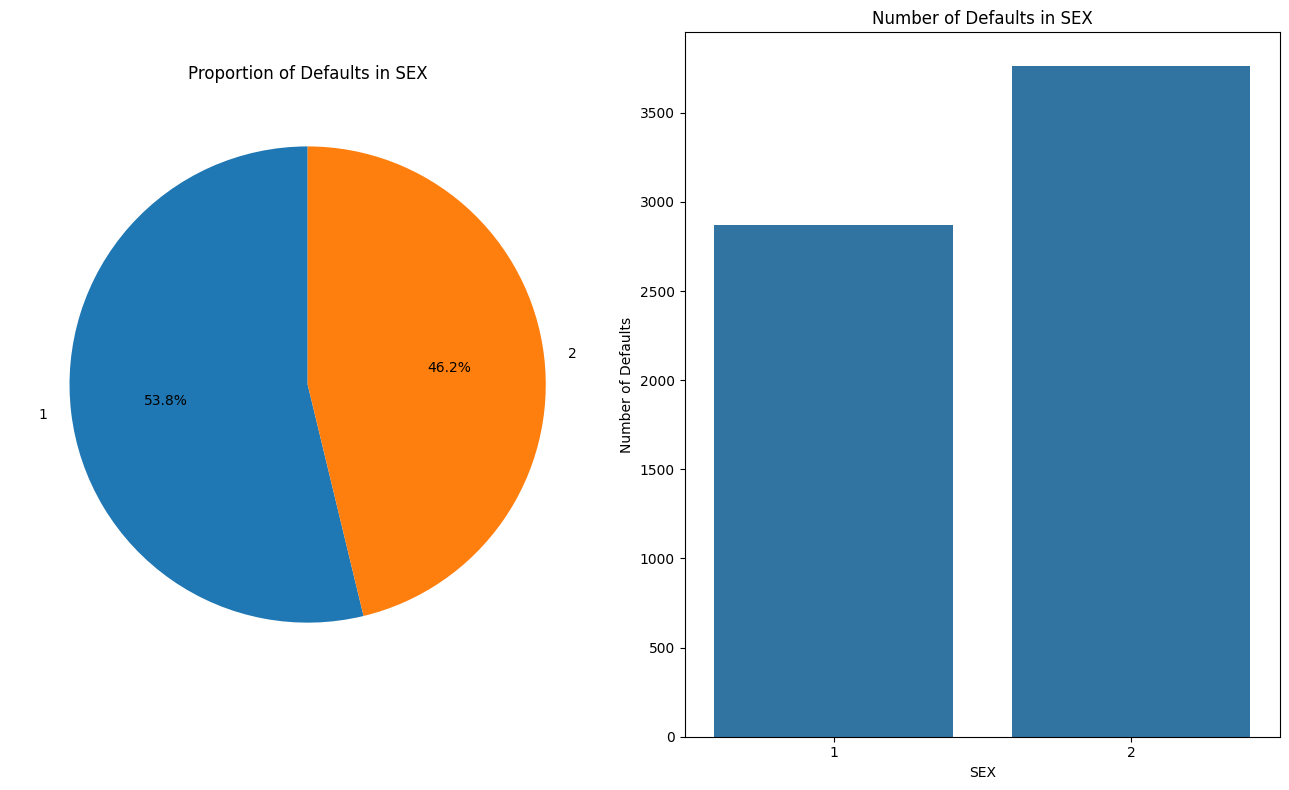

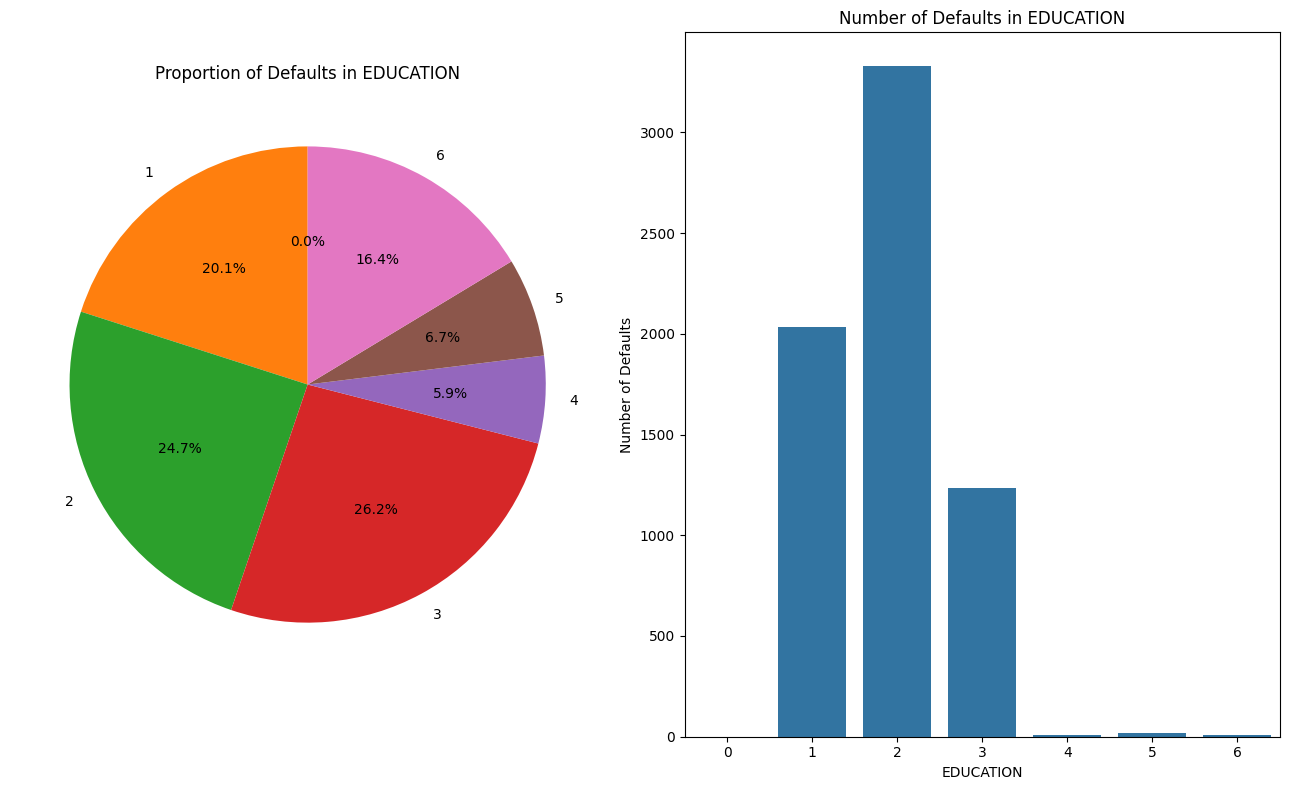

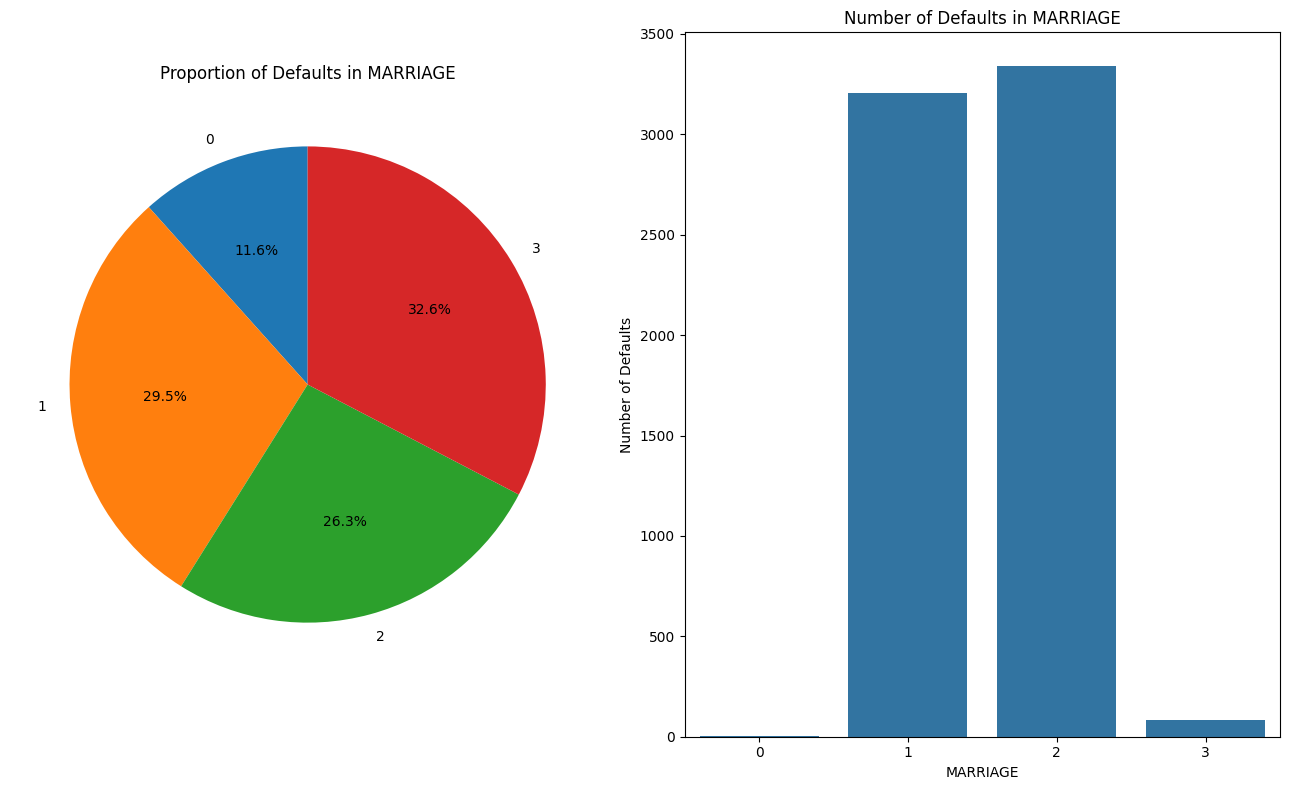

In [4]:
for col in categorical_vars:
    fig, axes = plt.subplots(ncols=2, figsize=(13, 8))

    default_counts = df.groupby([col])['default.payment.next.month'].sum()
    total_counts = df[col].value_counts()

    (default_counts / total_counts).plot(kind="pie", ax=axes[0], autopct='%1.1f%%', startangle=90)
    axes[0].set_ylabel('')  
    axes[0].set_title(f'Proportion of Defaults in {col}')

    sns.barplot(x=default_counts.index, y=default_counts.values, ax=axes[1])
    axes[1].set_title(f'Number of Defaults in {col}')
    axes[1].set_xlabel(col)
    axes[1].set_ylabel('Number of Defaults')

    plt.tight_layout()
    plt.show()


We can see that men have slightly higher default rates. 

In the education category, those in Grad School have higher default rates, followed by those in university, and then those in high school. The other education categories barely show on the plot in comparison. Finally,
we can see a similar number of defaults between those married and single, with the unknown and 0 categories having much less defaults. 

Now lets take a look at our Numerical variables. 

In [5]:
numerical_vars = ['LIMIT_BAL', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6',
                  'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6',
                  'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

df[numerical_vars].describe()

,LIMIT_BAL,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000
mean,167484.322667,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,-0.266200,-0.291100,51223.330900,49179.075167,4.701315e+04,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567
std,129747.661567,9.217904,1.123802,1.197186,1.196868,1.169139,1.133187,1.149988,73635.860576,71173.768783,6.934939e+04,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775
min,10000.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-165580.000000,-69777.000000,-1.572640e+05,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000
25%,50000.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,3558.750000,2984.750000,2.666250e+03,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000
50%,140000.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,22381.500000,21200.000000,2.008850e+04,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000
75%,240000.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,67091.000000,64006.250000,6.016475e+04,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000
max,1000000.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,964511.000000,983931.000000,1.664089e+06,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000


We can also see the average value of the of credit limit balance is 167,484. 
The standard deviation for it is fairly large, with a max value of 1M. 


Finally, we can see that the mean of the default.payment.next.month column is ~0.22. This means that 22% of cards will default next month, since since 0 means the card wont default, and 1 means it will.


To get a more clear sense of the class distribution, we can print the number of values in each class:

In [6]:
df['default.payment.next.month'].value_counts() # Class distribution

default.payment.next.month
0    23364
1     6636
Name: count, dtype: int64

We can see that 23,364 cards wont default next month, and 6,636 will.

Now lets visualize our numerical data:

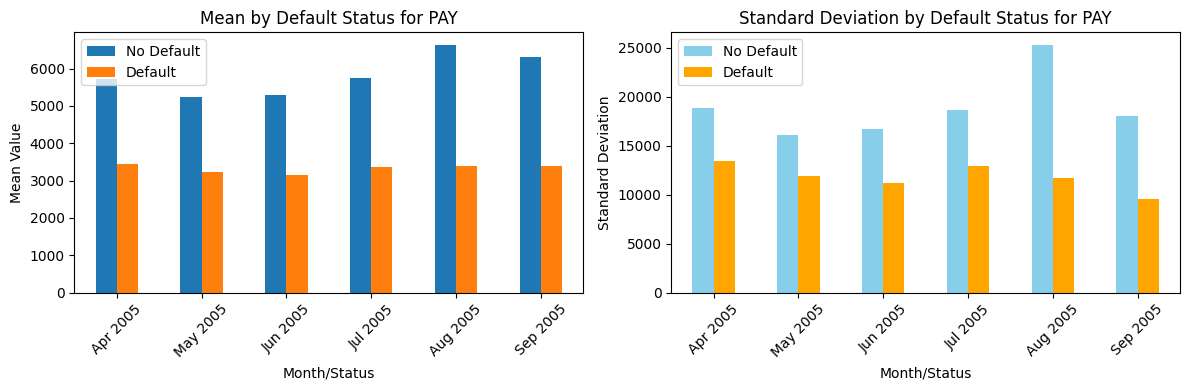

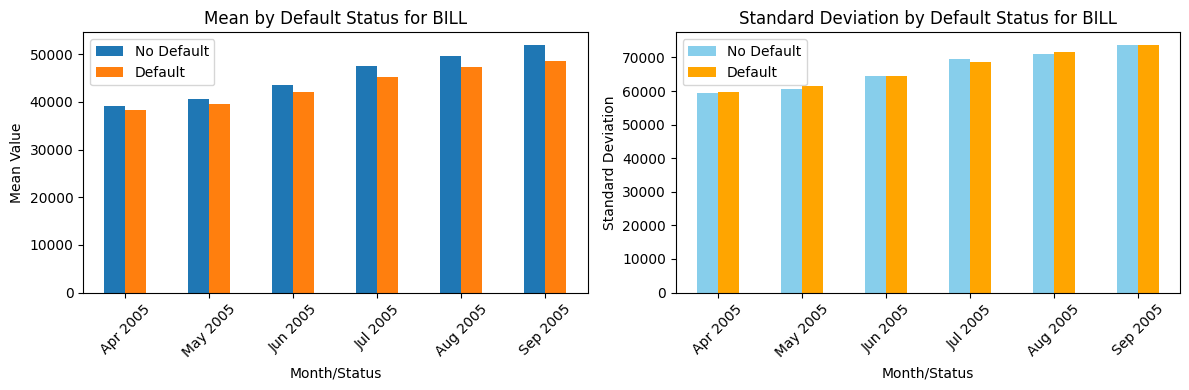

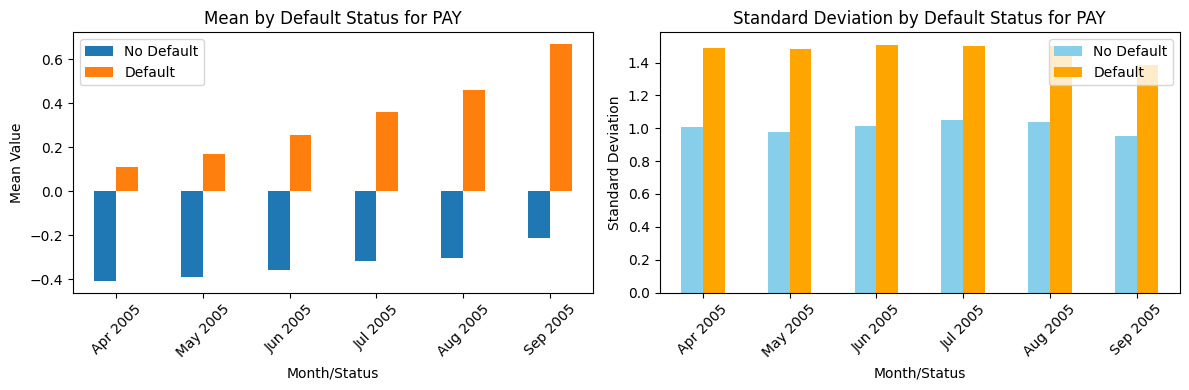

In [7]:
# Payment amounts by months, reversed
pay_amt_columns = ['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6'][::-1]
pay_amt_labels = ['Sep 2005', 'Aug 2005', 'Jul 2005', 'Jun 2005', 'May 2005', 'Apr 2005'][::-1]

# Bill statements by months, reversed
bill_amt_columns = ['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6'][::-1]
bill_amt_labels = ['Sep 2005', 'Aug 2005', 'Jul 2005', 'Jun 2005', 'May 2005', 'Apr 2005'][::-1]

# Repayment status by months, reversed
repayment_status_columns = ['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6'][::-1]
repayment_status_labels = ['Sep 2005', 'Aug 2005', 'Jul 2005', 'Jun 2005', 'May 2005', 'Apr 2005'][::-1]

def plot_stats_by_default(columns, labels, data):
    # Calculating statistics
    means = data.groupby('default.payment.next.month')[columns].mean().T
    std_devs = data.groupby('default.payment.next.month')[columns].std().T
    means.columns = ['No Default', 'Default']
    std_devs.columns = ['No Default', 'Default']
    means.index = labels
    std_devs.index = labels

    # Plotting
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 4))  # Adjusted figsize for two plots
    means.plot(kind='bar', ax=ax1)
    ax1.set_title('Mean by Default Status for ' + columns[0].split('_')[0])
    ax1.set_ylabel('Mean Value')
    ax1.set_xlabel('Month/Status')
    ax1.tick_params(axis='x', rotation=45)

    std_devs.plot(kind='bar', ax=ax2, color=['skyblue', 'orange'])
    ax2.set_title('Standard Deviation by Default Status for ' + columns[0].split('_')[0])
    ax2.set_ylabel('Standard Deviation')
    ax2.set_xlabel('Month/Status')
    ax2.tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

plot_stats_by_default(pay_amt_columns, pay_amt_labels, df)
plot_stats_by_default(bill_amt_columns, bill_amt_labels, df)
plot_stats_by_default(repayment_status_columns, repayment_status_labels, df)


Above we can see the average number of defaults are relatively consistent across the months, with slight fluctations between may-july. Time of year is unlikely to be a big factor in predicting default rates. The standard deviation of the default rates do vary a bit dramatically throughout the year. This is worth looking into. 

For the mean of the bill statements, we see that they're highest during september and go down in aug, jul, jun, may, and apr respectively. They have a fairly consistent spread, that follows the pattern of the mean. 

The final chart illustrates the mean values of the repayment status (where negative values indicate timely payment and higher positive values indicate delays), compared between defaulters and non-defaulters. We see a clear trend of defaulters having higher payment statuus as the months go on, whereas the non-defaulters mainly start out with timely payments but slowly get more and more delays. We also see a consistent spread of our dataset here.


## 3. Data Preparation and Transformation ## 

**3.1. Data Cleaning:**


Before we move on to feature engineering, let's check to see if there is any missing data:

In [8]:
df.isnull().sum()

ID                            0
LIMIT_BAL                     0
SEX                           0
EDUCATION                     0
MARRIAGE                      0
AGE                           0
PAY_0                         0
PAY_2                         0
PAY_3                         0
PAY_4                         0
PAY_5                         0
PAY_6                         0
BILL_AMT1                     0
BILL_AMT2                     0
BILL_AMT3                     0
BILL_AMT4                     0
BILL_AMT5                     0
BILL_AMT6                     0
PAY_AMT1                      0
PAY_AMT2                      0
PAY_AMT3                      0
PAY_AMT4                      0
PAY_AMT5                      0
PAY_AMT6                      0
default.payment.next.month    0
dtype: int64

Fortunately for us, there are no Null Values. 

Now lets address the inconsistencies we saw with some of the categories earlier

In [9]:
df['EDUCATION'] = df['EDUCATION'].replace({0: 4, 5: 4, 6: 4})
df['MARRIAGE'] = df['MARRIAGE'].replace({0: 3})

**3.2. Data Splitting:**

Now we will split our dataset into training and testing sets using a 70/30 split to prepare for model training and evaluation. We will also define a function `adjust_categories` to address inconsistencies observed in the 'EDUCATION' and 'MARRIAGE' columns during EDA. 

In [10]:
X = df.drop('default.payment.next.month', axis=1)  # Features
y = df['default.payment.next.month']               # Target 

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=76
)

This function will remap categories '0', '5', and '6' in 'EDUCATION' to category '4', effectively merging them. We are also merging the unlabeled category '0' in 'MARRIAGE' with category '3'. 

**3.3. Preprocessing:**

Lets define the columns for different preprocessing steps. Numerical columns will be standardized using `StandardScaler`.  The 'SEX' column, being binary, will be transformed using `OneHotEncoder` with the `drop='if_binary'` option. Lastly, the 'PAY' status columns, representing ordinal data, will be handled by `OrdinalEncoder`, setting  `handle_unknown='use_encoded_value'` and `unknown_value=-1` to manage potential unknown values.


In [11]:
# Define columns
numerical_cols = ['LIMIT_BAL', 'AGE', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
categorical_ordinal_cols = ['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
categorical_binary_cols = ['SEX']
categorical_onehot_cols = ['EDUCATION', 'MARRIAGE']

# Defining the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),  # Scale numerical columns
        ('cat_bin', OneHotEncoder(drop='if_binary'), categorical_binary_cols),  # Binary encode SEX
        ('cat_ord', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), categorical_ordinal_cols),  # Ordinal encode payment history
        ('cat_onehot', OneHotEncoder(), categorical_onehot_cols)  # OneHot encode EDUCATION and MARRIAGE
    ])

## 4. Model Selection and Evaluation

### 4.1 Baseline Model (Dummy Classifier): ###


Before diving into complex models, lets establish a baseline using a DummyClassifier. This classifier will be using the 'most_frequent' strategy, always predicting the majority class and giving us a good baseline. This baseline will help us understand if more sophisticated models provide a significant improvement.

In [12]:
# Pipeline for the DummyClassifier
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DummyClassifier(strategy='most_frequent'))
])

# Fit the pipeline to the training data
pipeline.fit(X_train, y_train)

# Predictions
y_pred = pipeline.predict(X_test)

# Evaluate the model
print("Train Score:", pipeline.score(X_train, y_train))
print("Test Score:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred, zero_division=0))

# Cross-validation scores
cv_scores = cross_val_score(pipeline, X, y, cv=5, scoring='accuracy')
print("Cross-validation scores:", cv_scores)
print("Mean CV Score:", cv_scores.mean())


Train Score: 0.7781428571428571
Test Score: 0.7803333333333333
Confusion Matrix:
 [[7023    0]
 [1977    0]]
Classification Report:
               precision    recall  f1-score   support

           0       0.78      1.00      0.88      7023
           1       0.00      0.00      0.00      1977

    accuracy                           0.78      9000
   macro avg       0.39      0.50      0.44      9000
weighted avg       0.61      0.78      0.68      9000

Cross-validation scores: [0.77866667 0.77883333 0.77883333 0.77883333 0.77883333]
Mean CV Score: 0.7788000000000002


We can see that the Dummy classifier gets a high-score, but this is decieving because as noted earlier, there is a 
strong class imbalance in this dataset. This is evident in the f1-score, and the precision and recall scores which tell us that the dummy classifier did not predict any cases of default correctly. 

### 4.2 Linear Models (Logistic Regression): ###

Lets now try out a LogisticRegression model. To address the class imbalance, we will use SMOTE (Synthetic Minority Over-sampling Technique) to oversample the minority class within an ImbPipeline. Furthermore, we utilize GridSearchCV to optimize the model's regularization parameter (C), looking to find the best balance between bias and variance.

In [13]:
model_pipeline = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=76)),
    ('classifier', LogisticRegression(random_state=76))
])

# Define the hyperparameter space 
param_grid = {
    'classifier__C': [0.01, 0.1, 1, 10, 100]  # Regularization parameter
}

grid_search = GridSearchCV(model_pipeline, param_grid, scoring='f1', cv=5, verbose=1)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)

print("Best hyperparameters:", grid_search.best_params_)

print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

cv_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='f1')
print("F1 Score - CV Scores:", cv_scores)
print("F1 Score - Mean:", cv_scores.mean())
print("F1 Score - Standard Deviation:", cv_scores.std())

Fitting 5 folds for each of 5 candidates, totalling 25 fits


/opt/homebrew/Cellar/jupyterlab/4.2.1/libexec/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/homebrew/Cellar/jupyterlab/4.2.1/libexec/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.or

Best hyperparameters: {'classifier__C': 0.01}
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.71      0.79      7023
           1       0.39      0.64      0.48      1977

    accuracy                           0.70      9000
   macro avg       0.63      0.68      0.63      9000
weighted avg       0.77      0.70      0.72      9000

Confusion Matrix:
 [[5014 2009]
 [ 712 1265]]
F1 Score - CV Scores: [0.47804474 0.48125756 0.48029863 0.48026868 0.47577442]
F1 Score - Mean: 0.47912880673167646
F1 Score - Standard Deviation: 0.0019812354466800246


The best performing Logistic Regression model achieved an F1-score of approximately 0.48. While the overall accuracy may seem lower compared to the dummy classifier, the focus is on improving the F1-score, which balances precision and recall, crucial for identifying potential defaulters. Our model demonstrates a marked improvement in recall for the minority class, indicating a better ability to correctly classify potential defaults compared to the baseline.

### 4.3 Non-Linear Models: ###


Now we will explore non-linear models in order to try and capture more complex relationships within the data: Support Vector Machines (SVM), Decision Tree, and XGBoost (a tree-based ensemble method). Each model, coupled with our preprocessing and SMOTE oversampling, is evaluated using 5-fold cross-validation, measuring accuracy, precision, recall, and F1-score. To find the best configuration, we'll also use GridSearchCV to systematically test a range of hyperparameters, aiming to maximize the weighted F1-score. 

**4.3.1. XGboost**

Lets explore and optimize an XGBoost model, a  tree-based ensemble method known for its performance in classification tasks.

In [14]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier


# XGBoost parameters
xgb_params = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [3, 5, 7],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__subsample': [0.6, 0.8, 1.0],
    'classifier__min_child_weight': [1, 3, 5],
    'classifier__gamma': [0, 0.1, 0.2]
}

# Create the pipeline
xgb_pipeline = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=76)),
    ('classifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=76))
])

# Use stratified k-fold to maintain class distribution
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=76)

# Setup GridSearchCV
xgb_grid_search = GridSearchCV(xgb_pipeline, xgb_params, cv=stratified_kfold, scoring='f1_weighted', verbose=1)
xgb_grid_search.fit(X_train, y_train)

# Predict using the best model
y_pred = xgb_grid_search.predict(X_test)

# Print best model results
print("Best parameters:", xgb_grid_search.best_params_)
print("Best cross-validation F1 score: {:.3f}".format(xgb_grid_search.best_score_))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Print mean fit and score time
cv_results = xgb_grid_search.cv_results_
print(f"Mean Fit Time: {cv_results['mean_fit_time'].mean():.4f} seconds")
print(f"Mean Score Time: {cv_results['mean_score_time'].mean():.4f} seconds")


Fitting 5 folds for each of 486 candidates, totalling 2430 fits
Best parameters: {'classifier__gamma': 0, 'classifier__learning_rate': 0.2, 'classifier__max_depth': 3, 'classifier__min_child_weight': 5, 'classifier__n_estimators': 200, 'classifier__subsample': 1.0}
Best cross-validation F1 score: 0.797
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.91      0.88      7023
           1       0.59      0.44      0.50      1977

    accuracy                           0.81      9000
   macro avg       0.72      0.68      0.69      9000
weighted avg       0.79      0.81      0.80      9000

Confusion Matrix:
 [[6410  613]
 [1107  870]]
Mean Fit Time: 0.3785 seconds
Mean Score Time: 0.0076 seconds


After conducting the grid search over the specified hyperparameter space, our optimized XGBoost model achieved a cross-validated weighted F1-score of 0.797. This score represents a notable improvement compared to our previous models, suggesting that the tuning process has successfully enhanced the model's predictive capabilities. Examining the classification report and confusion matrix, we observe improved precision and recall for both classes, indicating a more balanced and robust model for predicting credit card defaults.

**4.3.2. SVM**

Next, Lets assess the performance of a Support Vector Machine (SVM) model. Due to the potential computational intensity of SVM, particularly with larger datasets, we'll employ RandomizedSearchCV for hyperparameter optimization. This approach allows for a more efficient exploration of the hyperparameter space by randomly sampling a specified number of combinations. We'll use an exponential distribution for the regularization parameter (C) and explore both radial basis function (rbf) and polynomial (poly) kernels.


In [15]:
# SVM hyperparameters
svm_params = {
    'classifier__C': expon(scale=100),  # Using exponential distribution for C
    'classifier__gamma': ['scale'],  # Fixed to 'scale' to handle different data scales
    'classifier__kernel': ['rbf', 'poly']  # Exploring radial basis function and polynomial kernels
}

# Create the pipeline with SMOTE and SVC
svm_pipeline = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=76, sampling_strategy='not majority')),  # Adjusted SMOTE strategy
    ('classifier', SVC(random_state=76))
])

# Setup RandomizedSearchCV
svm_random_search = RandomizedSearchCV(
    svm_pipeline, svm_params, n_iter=5, cv=5, scoring='f1_weighted', 
    verbose=1, random_state=76, n_jobs=-1  # Utilize all available cores
)
svm_random_search.fit(X_train, y_train)

# Predict using the best model
y_pred = svm_random_search.predict(X_test)

# Output the best parameters and F1 score
print("Best parameters:", svm_random_search.best_params_)
print("Best cross-validation F1 score: {:.3f}".format(svm_random_search.best_score_))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Optional: Print mean fit and score time if you have captured cv_results during grid search
cv_results = svm_random_search.cv_results_
print(f"Mean Fit Time: {cv_results['mean_fit_time'].mean():.4f} seconds")
print(f"Mean Score Time: {cv_results['mean_score_time'].mean():.4f} seconds")


Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best parameters: {'classifier__C': 2.6260380923239635, 'classifier__gamma': 'scale', 'classifier__kernel': 'rbf'}
Best cross-validation F1 score: 0.784
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.85      0.86      7023
           1       0.51      0.56      0.53      1977

    accuracy                           0.79      9000
   macro avg       0.69      0.70      0.70      9000
weighted avg       0.79      0.79      0.79      9000

Confusion Matrix:
 [[5975 1048]
 [ 876 1101]]
Mean Fit Time: 69.5654 seconds
Mean Score Time: 3.5236 seconds


Our optimized SVM model attained a cross-validated weighted F1-score of 0.783, indicating competitive performance. The classification report and confusion matrix reveal a balanced performance across both classes, though slightly lagging behind the XGBoost model. Notably, SVM training and scoring times are considerably longer, highlighting a potential drawback if computational efficiency is a priority.

**4.3.3. Decision Tree**


Finally lets evaluate a Decision Tree model. We will optimize hyperparameters such as max_depth, min_samples_split, and min_samples_leaf using GridSearchCV to find the optimal settings that maximize the weighted F1-score on our dataset.

In [16]:
# Decision Tree hyperparameters
decision_tree_params = {
    'classifier__max_depth': [None, 10, 20, 30, 40, 50],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

# Create the pipeline with the Decision Tree classifier
decision_tree_pipeline = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=76)),
    ('classifier', DecisionTreeClassifier(random_state=76))
])

# Setup GridSearchCV for the Decision Tree
dt_grid_search = GridSearchCV(decision_tree_pipeline, decision_tree_params, cv=5, scoring='f1_weighted', verbose=1)
dt_grid_search.fit(X_train, y_train)

# Predict using the best model
y_pred = dt_grid_search.predict(X_test)

# Output the best parameters and F1 score
print("Best parameters:", dt_grid_search.best_params_)
print("Best cross-validation F1 score: {:.3f}".format(dt_grid_search.best_score_))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Optional: Print mean fit and score time if you have captured cv_results during grid search
cv_results = dt_grid_search.cv_results_
print(f"Mean Fit Time: {cv_results['mean_fit_time'].mean():.4f} seconds")
print(f"Mean Score Time: {cv_results['mean_score_time'].mean():.4f} seconds")


Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best parameters: {'classifier__max_depth': 10, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 10}
Best cross-validation F1 score: 0.750
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.84      0.85      7023
           1       0.48      0.51      0.49      1977

    accuracy                           0.77      9000
   macro avg       0.67      0.68      0.67      9000
weighted avg       0.78      0.77      0.77      9000

Confusion Matrix:
 [[5933 1090]
 [ 972 1005]]
Mean Fit Time: 0.4035 seconds
Mean Score Time: 0.0070 seconds


Our tuned Decision Tree model achieves a cross-validated weighted F1-score of 0.756, falling slightly behind the XGBoost and SVM models. 

**4.3.4. Results**


Out of the three tuned non-linear models (XGBoost, SVM, Decision Tree), XGBoost demonstrated the best performance, achieving the highest cross-validated weighted F1-score of 0.795.
While SVM showed competitive performance with a score of 0.783, its significantly longer training and scoring times could be a limiting factor. The Decision Tree, while computationally faster than SVM, lagged in performance with a score of 0.756.
Therefore, XGBoost appears to be the most promising model for predicting credit card defaults in our project. Now lets see if we can optimize our model and imrpove our scores even further in the next section.

## 5. Final Model Evaluation and Interpretation 

**5.1. Test Set Performance:**

In [17]:
# Our final XGBoost pipeline with the best parameters 
final_xgb_pipeline = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=76)),
    ('classifier', XGBClassifier(
        use_label_encoder=False, 
        eval_metric='logloss', 
        random_state=76,
        gamma=0, 
        learning_rate=0.2, 
        max_depth=3, 
        min_child_weight=5, 
        n_estimators=200, 
        subsample=1.0
    ))
])

In [18]:
# Fit and predict using our best model
final_xgb_pipeline.fit(X_train, y_train)
y_pred = final_xgb_pipeline.predict(X_test)

In [19]:
# Evaluation Metrics
print("Test Set Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1-score:", f1_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Test Set Performance:
Accuracy: 0.8088888888888889
Precision: 0.5866486850977748
Recall: 0.4400606980273141
F1-score: 0.5028901734104047
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.91      0.88      7023
           1       0.59      0.44      0.50      1977

    accuracy                           0.81      9000
   macro avg       0.72      0.68      0.69      9000
weighted avg       0.79      0.81      0.80      9000

Confusion Matrix:
 [[6410  613]
 [1107  870]]


We can see that our XGBoost model achieved an overall accuracy of 80.89% on the test set, indicating it is reasonably effective in identifying credit card defaults. 

However, there is room for improvement. 
The precision of 58.66% shows that when predicting defaults, the model is correct around 59% of the time, but the recall of 44.01% indicates it only identifies 44% of all actual default cases. The F1-score of 50.29% highlights a challenge in balancing precision and recall, suggesting the model may be conservative in predicting defaults. 

**5.2. Model Interpretability**

Lets take a look at what factors were most useful when prediciting defults. 

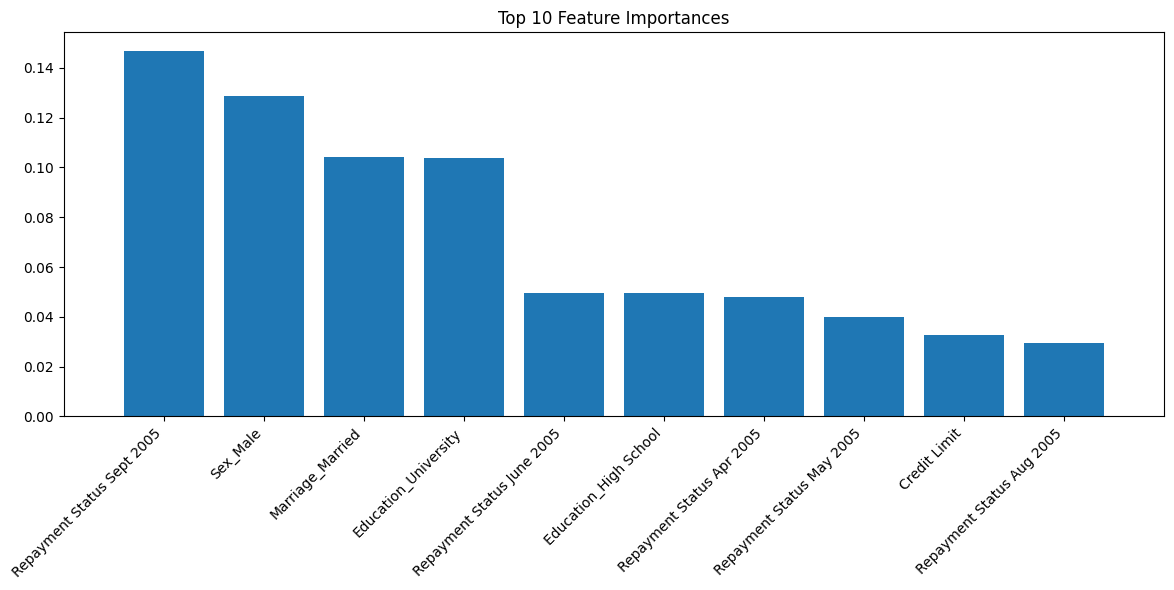

In [20]:
feature_names = (numerical_cols + 
                 list(final_xgb_pipeline.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(categorical_binary_cols)) +
                 categorical_ordinal_cols + 
                 list(final_xgb_pipeline.named_steps['preprocessor'].transformers_[3][1].get_feature_names_out(categorical_onehot_cols)))

# Rename Features For Better Interpretability
feature_names = [
    'Credit Limit', 'Age', 
    'Bill Amt Sept 2005', 'Bill Amt Aug 2005', 'Bill Amt July 2005',
    'Bill Amt June 2005', 'Bill Amt May 2005', 'Bill Amt Apr 2005',
    'Payment Amt Sept 2005', 'Payment Amt Aug 2005', 'Payment Amt July 2005', 
    'Payment Amt June 2005', 'Payment Amt May 2005', 'Payment Amt Apr 2005',
    'Sex_Male', # One-hot encoded: Assuming you dropped 'female' during encoding 
    'Repayment Status Sept 2005', 'Repayment Status Aug 2005', 'Repayment Status July 2005', 
    'Repayment Status June 2005', 'Repayment Status May 2005', 'Repayment Status Apr 2005',
    'Education_Grad School', 'Education_University', 'Education_High School', 'Education_Others', 
    'Marriage_Married', 'Marriage_Single', 'Marriage_Others' # One-hot encoded 
] 

# Feature Importance Plot
importances = final_xgb_pipeline.named_steps['classifier'].feature_importances_
indices = np.argsort(importances)[::-1] 

plt.figure(figsize=(12, 6))
plt.title("Top 10 Feature Importances")
plt.bar(range(10), importances[indices[:10]], align="center")
plt.xticks(range(10), [feature_names[i] for i in indices[:10]], rotation=45, ha='right')
plt.xlim([-1, 10])
plt.tight_layout()
plt.show()

From the plot above, we can see that higher payment delays towards the end of the year were highly predictive of customer defults. On top of that, those defulting are more likely to be male, married, and have post-secondary education. This makes intuitve sense, given that some of those categories often have inherent fiscal responsibility. After that, we see that payment delays still play a cruical role in predicting credit card defaults.

## 6. Conclusion and Recommendations 


**6.1. Summary of Findings:**
  
This project aimed to predict credit card defaults using demographic and credit information from 30,000 clients in Taiwan. Utilizing an extensive dataset featuring various attributes of credit card clients, the project framed predicting defaults as a binary classification problem. After exploring several models, the XGBoost classifier was identified as the most effective, optimized through grid search to achieve an F1-score of approximately 0.50 on the test set. This model demonstrated a robust capability to predict defaults with an accuracy of around 81%, significantly better than baseline models.


**6.2. Limitations and Future Work:**

Despite its success, the project has limitations that could be addressed in future work. Firstly, the dataset is restricted to a single geographical region and time frame, which may not generalize to other contexts or time periods. Moreover, the model might benefit from additional feature engineering or the inclusion of more diverse data types, such as real-time transaction data or more detailed behavioral profiles.

Future enhancements could include experimenting with more advanced machine learning techniques, such as deep learning models, which might capture complex patterns in large-scale data more effectively. Furthermore, integrating a larger and more diverse dataset could help in improving the model's robustness and applicability to different demographic groups or economic conditions.


**6.3.  Business Implications:**

The predictive model highlights payment delays and demographic factors like gender, marital status, and education as key predictors of credit card defaults. Financial institutions can use these insights to monitor payment patterns more closely and intervene early when late payments are detected. Tailored communication strategies and financial literacy programs could be developed for demographics identified as high-risk. Implementing personalized credit monitoring and customized credit offers, such as flexible payment options or proactive debt restructuring, could prevent defaults. These strategies not only reduce default rates but also enhance customer loyalty and improve risk management.